In [1]:
# !pip3 install kaggle
# import os
# os.environ['KAGGLE_USERNAME'] = 'artijain3'
# os.environ['KAGGLE_KEY'] = '484f16212bb2cff3a856f3186182ba79'

# !kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

# !unzip gtsrb-german-traffic-sign.zip

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models
import torch
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
class GTSRBDataset(datasets.ImageFolder):
    def __init__(self, csv_file, img_dir, transform=None):
        self.csv_data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.class_to_idx = {int(row['ClassId']): row['Path'].split('/')[0] for _, row in self.csv_data.iterrows()}

    def __len__(self):
        return len(self.csv_data)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.csv_data.iloc[index]['Path'])
        image = datasets.folder.default_loader(img_path)
        label = int(self.csv_data.iloc[index]['ClassId'])

        if self.transform:
            image = self.transform(image)

        return image, label

# Defined transformations
transformations = transforms.Compose([
    transforms.Resize((224, 224)), # InceptionV3 expects 299x299
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

base_dir = "./gtsrb-german-traffic-sign"  # Adjust this path as necessary
train_data = GTSRBDataset(csv_file=os.path.join(base_dir, 'Train.csv'), img_dir=base_dir, transform=transformations)
test_data = GTSRBDataset(csv_file=os.path.join(base_dir, 'Test.csv'), img_dir=base_dir, transform=transformations)

# train val split
train_size = int(0.8 * len(train_data))
valid_size = len(train_data) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_data, [train_size, valid_size])

# Dataloaders for train val test
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)


In [4]:
# Loading pretrained Inception V3 model
model = models.resnet50(pretrained=True)
# Freeze parameters
for param in model.parameters():
    param.requires_grad = False
# Replace the last layer with 43 classes in GTSRB
model.fc = nn.Linear(model.fc.in_features, 43)

# if torch.cuda.is_available():
#     model = model.cuda()

device = torch.device("mps")
model= model.to(device)


/Users/artijain/anaconda3/envs/deeplearning/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/artijain/anaconda3/envs/deeplearning/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
optimizer = optim.Adam(model.fc.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
criterion = nn.CrossEntropyLoss()

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    pbar = tqdm(loader, desc="Training", unit="batch")
    for inputs, labels in pbar:
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        else:
            inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # Handling aux logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_postfix(loss=loss.item())
    return running_loss / len(loader)

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    pbar = tqdm(loader, desc="Validating", unit="batch")
    with torch.no_grad():
        for inputs, labels in loader:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            else:
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            pbar.set_postfix(loss=loss.item())
    f1 = f1_score(all_labels, all_preds, average='weighted')
    accuracy = accuracy_score(all_labels, all_preds)
    return running_loss / len(loader), f1, accuracy

def test_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            else:
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    test_loss = running_loss / len(loader)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    accuracy = accuracy_score(all_labels, all_preds)
    return test_loss, f1, accuracy


In [6]:
# Training the model
num_epochs = 70
train_losses, valid_losses, valid_f1s, valid_accuracies = [], [], [], []
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    valid_loss, f1, accuracy = validate(model, valid_loader, criterion)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_f1s.append(f1)
    valid_accuracies.append(accuracy)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, F1: {f1:.4f}, Accuracy: {accuracy:.4f}')



Training:   0%|          | 0/246 [00:00<?, ?batch/s]

Validating:   0%|          | 0/62 [00:24<?, ?batch/s, loss=0.95] 


Epoch 1, Train Loss: 1.5457, Valid Loss: 0.9661, F1: 0.7370, Accuracy: 0.7437


Validating:   0%|          | 0/62 [00:24<?, ?batch/s, loss=0.714]


Epoch 2, Train Loss: 0.8060, Valid Loss: 0.7235, F1: 0.7911, Accuracy: 0.7927


Validating:   0%|          | 0/62 [00:23<?, ?batch/s, loss=0.579]


Epoch 3, Train Loss: 0.6471, Valid Loss: 0.6316, F1: 0.8077, Accuracy: 0.8088


Validating:   0%|          | 0/62 [00:23<?, ?batch/s, loss=0.453]


Epoch 4, Train Loss: 0.5569, Valid Loss: 0.5659, F1: 0.8294, Accuracy: 0.8305


Validating:   0%|          | 0/62 [00:25<?, ?batch/s, loss=0.463]


Epoch 5, Train Loss: 0.4998, Valid Loss: 0.5346, F1: 0.8365, Accuracy: 0.8383


Validating:   0%|          | 0/62 [00:25<?, ?batch/s, loss=0.414]


Epoch 6, Train Loss: 0.4514, Valid Loss: 0.5270, F1: 0.8350, Accuracy: 0.8364


Validating:   0%|          | 0/62 [00:24<?, ?batch/s, loss=0.467]


Epoch 7, Train Loss: 0.4280, Valid Loss: 0.5084, F1: 0.8422, Accuracy: 0.8435


Validating:   0%|          | 0/62 [00:24<?, ?batch/s, loss=0.413]


Epoch 8, Train Loss: 0.4002, Valid Loss: 0.4596, F1: 0.8556, Accuracy: 0.8567


Validating:   0%|          | 0/62 [00:25<?, ?batch/s, loss=0.416]


Epoch 9, Train Loss: 0.3774, Valid Loss: 0.4630, F1: 0.8523, Accuracy: 0.8536


Validating:   0%|          | 0/62 [00:23<?, ?batch/s, loss=0.357]


Epoch 10, Train Loss: 0.3629, Valid Loss: 0.4404, F1: 0.8640, Accuracy: 0.8637


Validating:   0%|          | 0/62 [00:23<?, ?batch/s, loss=0.355]


Epoch 11, Train Loss: 0.3431, Valid Loss: 0.4195, F1: 0.8677, Accuracy: 0.8680


Validating:   0%|          | 0/62 [00:23<?, ?batch/s, loss=0.3]  


Epoch 12, Train Loss: 0.3288, Valid Loss: 0.3903, F1: 0.8753, Accuracy: 0.8754


Validating:   0%|          | 0/62 [00:24<?, ?batch/s, loss=0.334]


Epoch 13, Train Loss: 0.3143, Valid Loss: 0.4069, F1: 0.8694, Accuracy: 0.8690


Validating:   0%|          | 0/62 [00:24<?, ?batch/s, loss=0.274]


Epoch 14, Train Loss: 0.3063, Valid Loss: 0.3915, F1: 0.8758, Accuracy: 0.8757


Validating:   0%|          | 0/62 [00:24<?, ?batch/s, loss=0.476]


Epoch 15, Train Loss: 0.2945, Valid Loss: 0.4055, F1: 0.8698, Accuracy: 0.8702


Validating:   0%|          | 0/62 [03:46<?, ?batch/s, loss=0.285]


Epoch 16, Train Loss: 0.2872, Valid Loss: 0.3756, F1: 0.8797, Accuracy: 0.8794


Validating:   0%|          | 0/62 [00:35<?, ?batch/s, loss=0.275]


Epoch 17, Train Loss: 0.2782, Valid Loss: 0.3854, F1: 0.8705, Accuracy: 0.8699


Validating:   0%|          | 0/62 [00:35<?, ?batch/s, loss=0.348]


Epoch 18, Train Loss: 0.2668, Valid Loss: 0.3665, F1: 0.8789, Accuracy: 0.8785


Validating:   0%|          | 0/62 [00:33<?, ?batch/s, loss=0.254]


Epoch 19, Train Loss: 0.2635, Valid Loss: 0.3693, F1: 0.8759, Accuracy: 0.8764


Validating:   0%|          | 0/62 [00:33<?, ?batch/s, loss=0.334]


Epoch 20, Train Loss: 0.2507, Valid Loss: 0.3670, F1: 0.8832, Accuracy: 0.8824


Validating:   0%|          | 0/62 [00:33<?, ?batch/s, loss=0.292]


Epoch 21, Train Loss: 0.2431, Valid Loss: 0.3498, F1: 0.8827, Accuracy: 0.8836


Validating:   0%|          | 0/62 [00:34<?, ?batch/s, loss=0.227]


Epoch 22, Train Loss: 0.2334, Valid Loss: 0.3519, F1: 0.8846, Accuracy: 0.8855


Validating:   0%|          | 0/62 [00:35<?, ?batch/s, loss=0.22] 


Epoch 23, Train Loss: 0.2274, Valid Loss: 0.3641, F1: 0.8817, Accuracy: 0.8814


Validating:   0%|          | 0/62 [00:32<?, ?batch/s, loss=0.239]


Epoch 24, Train Loss: 0.2325, Valid Loss: 0.3376, F1: 0.8853, Accuracy: 0.8854


Validating:   0%|          | 0/62 [00:35<?, ?batch/s, loss=0.212]


Epoch 25, Train Loss: 0.2238, Valid Loss: 0.3282, F1: 0.8919, Accuracy: 0.8922


Validating:   0%|          | 0/62 [08:07<?, ?batch/s, loss=0.283]


Epoch 26, Train Loss: 0.2183, Valid Loss: 0.3366, F1: 0.8876, Accuracy: 0.8878


Validating:   0%|          | 0/62 [00:34<?, ?batch/s, loss=0.236]


Epoch 27, Train Loss: 0.2191, Valid Loss: 0.3614, F1: 0.8785, Accuracy: 0.8790


Validating:   0%|          | 0/62 [00:33<?, ?batch/s, loss=0.285]


Epoch 28, Train Loss: 0.2081, Valid Loss: 0.3469, F1: 0.8827, Accuracy: 0.8829


Validating:   0%|          | 0/62 [00:33<?, ?batch/s, loss=0.243]


Epoch 29, Train Loss: 0.1989, Valid Loss: 0.3271, F1: 0.8924, Accuracy: 0.8931


Validating:   0%|          | 0/62 [00:31<?, ?batch/s, loss=0.252]


Epoch 30, Train Loss: 0.1929, Valid Loss: 0.3227, F1: 0.8934, Accuracy: 0.8929


Validating:   0%|          | 0/62 [00:33<?, ?batch/s, loss=0.278]


Epoch 31, Train Loss: 0.1909, Valid Loss: 0.3141, F1: 0.8970, Accuracy: 0.8967


Validating:   0%|          | 0/62 [00:34<?, ?batch/s, loss=0.293]


Epoch 32, Train Loss: 0.1896, Valid Loss: 0.3301, F1: 0.8918, Accuracy: 0.8920


Validating:   0%|          | 0/62 [00:33<?, ?batch/s, loss=0.218]


Epoch 33, Train Loss: 0.1991, Valid Loss: 0.3217, F1: 0.8917, Accuracy: 0.8916


Validating:   0%|          | 0/62 [00:35<?, ?batch/s, loss=0.273]


Epoch 34, Train Loss: 0.1874, Valid Loss: 0.3111, F1: 0.8988, Accuracy: 0.8991


Validating:   0%|          | 0/62 [00:32<?, ?batch/s, loss=0.284]


Epoch 35, Train Loss: 0.1765, Valid Loss: 0.3079, F1: 0.8990, Accuracy: 0.8988


Validating:   0%|          | 0/62 [00:33<?, ?batch/s, loss=0.308]


Epoch 36, Train Loss: 0.1797, Valid Loss: 0.3239, F1: 0.8957, Accuracy: 0.8958


Validating:   0%|          | 0/62 [00:33<?, ?batch/s, loss=0.192]


Epoch 37, Train Loss: 0.1733, Valid Loss: 0.3185, F1: 0.8949, Accuracy: 0.8948


Validating:   0%|          | 0/62 [00:34<?, ?batch/s, loss=0.295]


Epoch 38, Train Loss: 0.1682, Valid Loss: 0.3039, F1: 0.9022, Accuracy: 0.9017


Validating:   0%|          | 0/62 [00:32<?, ?batch/s, loss=0.268]


Epoch 39, Train Loss: 0.1659, Valid Loss: 0.2917, F1: 0.9019, Accuracy: 0.9021


Validating:   0%|          | 0/62 [00:35<?, ?batch/s, loss=0.259]


Epoch 40, Train Loss: 0.1615, Valid Loss: 0.3093, F1: 0.8930, Accuracy: 0.8930


Validating:   0%|          | 0/62 [06:01<?, ?batch/s, loss=0.264]


Epoch 41, Train Loss: 0.1660, Valid Loss: 0.3133, F1: 0.8957, Accuracy: 0.8956


Validating:   0%|          | 0/62 [13:36<?, ?batch/s, loss=0.226]


Epoch 42, Train Loss: 0.1590, Valid Loss: 0.3036, F1: 0.9004, Accuracy: 0.9005


Validating:   0%|          | 0/62 [00:24<?, ?batch/s, loss=0.266]


Epoch 43, Train Loss: 0.1600, Valid Loss: 0.3008, F1: 0.9036, Accuracy: 0.9032


Validating:   0%|          | 0/62 [00:25<?, ?batch/s, loss=0.175]


Epoch 44, Train Loss: 0.1579, Valid Loss: 0.2954, F1: 0.9010, Accuracy: 0.9005


Validating:   0%|          | 0/62 [00:25<?, ?batch/s, loss=0.229]


Epoch 45, Train Loss: 0.1511, Valid Loss: 0.2979, F1: 0.9005, Accuracy: 0.9003


Validating:   0%|          | 0/62 [00:25<?, ?batch/s, loss=0.216]


Epoch 46, Train Loss: 0.1490, Valid Loss: 0.3145, F1: 0.8984, Accuracy: 0.8988


Validating:   0%|          | 0/62 [00:23<?, ?batch/s, loss=0.256]


Epoch 47, Train Loss: 0.1523, Valid Loss: 0.2910, F1: 0.9050, Accuracy: 0.9051


Validating:   0%|          | 0/62 [00:24<?, ?batch/s, loss=0.288]


Epoch 48, Train Loss: 0.1437, Valid Loss: 0.3112, F1: 0.8968, Accuracy: 0.8967


Validating:   0%|          | 0/62 [00:24<?, ?batch/s, loss=0.274]


Epoch 49, Train Loss: 0.1496, Valid Loss: 0.2858, F1: 0.9064, Accuracy: 0.9063


Validating:   0%|          | 0/62 [00:24<?, ?batch/s, loss=0.264]


Epoch 50, Train Loss: 0.1425, Valid Loss: 0.2802, F1: 0.9083, Accuracy: 0.9081


Validating:   0%|          | 0/62 [00:24<?, ?batch/s, loss=0.264]


Epoch 51, Train Loss: 0.1466, Valid Loss: 0.2766, F1: 0.9118, Accuracy: 0.9116


Validating:   0%|          | 0/62 [00:24<?, ?batch/s, loss=0.321]


Epoch 52, Train Loss: 0.1358, Valid Loss: 0.3023, F1: 0.9013, Accuracy: 0.9016


Validating:   0%|          | 0/62 [00:24<?, ?batch/s, loss=0.222]


Epoch 53, Train Loss: 0.1359, Valid Loss: 0.2907, F1: 0.9024, Accuracy: 0.9022


Validating:   0%|          | 0/62 [00:25<?, ?batch/s, loss=0.263]


Epoch 54, Train Loss: 0.1285, Valid Loss: 0.2912, F1: 0.9042, Accuracy: 0.9044


Validating:   0%|          | 0/62 [00:25<?, ?batch/s, loss=0.293]


Epoch 55, Train Loss: 0.1253, Valid Loss: 0.2736, F1: 0.9131, Accuracy: 0.9133


Validating:   0%|          | 0/62 [00:24<?, ?batch/s, loss=0.229]


Epoch 56, Train Loss: 0.1266, Valid Loss: 0.2930, F1: 0.9048, Accuracy: 0.9039


Validating:   0%|          | 0/62 [00:24<?, ?batch/s, loss=0.203]


Epoch 57, Train Loss: 0.1268, Valid Loss: 0.2953, F1: 0.9031, Accuracy: 0.9024


Validating:   0%|          | 0/62 [00:25<?, ?batch/s, loss=0.22] 


Epoch 58, Train Loss: 0.1278, Valid Loss: 0.2761, F1: 0.9107, Accuracy: 0.9106


Validating:   0%|          | 0/62 [00:25<?, ?batch/s, loss=0.24] 


Epoch 59, Train Loss: 0.1305, Valid Loss: 0.2747, F1: 0.9053, Accuracy: 0.9056


Validating:   0%|          | 0/62 [00:24<?, ?batch/s, loss=0.314]


Epoch 60, Train Loss: 0.1215, Valid Loss: 0.3042, F1: 0.9025, Accuracy: 0.9022


Validating:   0%|          | 0/62 [00:24<?, ?batch/s, loss=0.257]


Epoch 61, Train Loss: 0.1174, Valid Loss: 0.2739, F1: 0.9096, Accuracy: 0.9096


Validating:   0%|          | 0/62 [00:24<?, ?batch/s, loss=0.325]


Epoch 62, Train Loss: 0.1242, Valid Loss: 0.2655, F1: 0.9140, Accuracy: 0.9137


Validating:   0%|          | 0/62 [00:25<?, ?batch/s, loss=0.224]


Epoch 63, Train Loss: 0.1217, Valid Loss: 0.2729, F1: 0.9122, Accuracy: 0.9121


Validating:   0%|          | 0/62 [00:24<?, ?batch/s, loss=0.286]


Epoch 64, Train Loss: 0.1170, Valid Loss: 0.2772, F1: 0.9093, Accuracy: 0.9092


Validating:   0%|          | 0/62 [00:25<?, ?batch/s, loss=0.304]


Epoch 65, Train Loss: 0.1149, Valid Loss: 0.2933, F1: 0.9052, Accuracy: 0.9050


Validating:   0%|          | 0/62 [00:24<?, ?batch/s, loss=0.198]


Epoch 66, Train Loss: 0.1282, Valid Loss: 0.2950, F1: 0.9033, Accuracy: 0.9028


Validating:   0%|          | 0/62 [00:25<?, ?batch/s, loss=0.344]


Epoch 67, Train Loss: 0.1252, Valid Loss: 0.2799, F1: 0.9085, Accuracy: 0.9084


Validating:   0%|          | 0/62 [00:24<?, ?batch/s, loss=0.204]


Epoch 68, Train Loss: 0.1158, Valid Loss: 0.2824, F1: 0.9047, Accuracy: 0.9041


Validating:   0%|          | 0/62 [00:24<?, ?batch/s, loss=0.229]


Epoch 69, Train Loss: 0.1081, Valid Loss: 0.2924, F1: 0.9046, Accuracy: 0.9041


Validating:   0%|          | 0/62 [00:24<?, ?batch/s, loss=0.268]

Epoch 70, Train Loss: 0.1106, Valid Loss: 0.2755, F1: 0.9118, Accuracy: 0.9121


In [12]:
def save_model(epochs, model, output_path):
    torch.save({'epoch':epochs, 'model_state':model.state_dict()}, output_path)
    
save_model(num_epochs, model, os.path.join(os.getcwd(), "finetuned_resnet.pth"))

In [13]:
# Testing the model
test_loss, test_f1, test_accuracy = test_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test F1: {test_f1:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 1.1393, Test F1: 0.7393, Test Accuracy: 0.7432


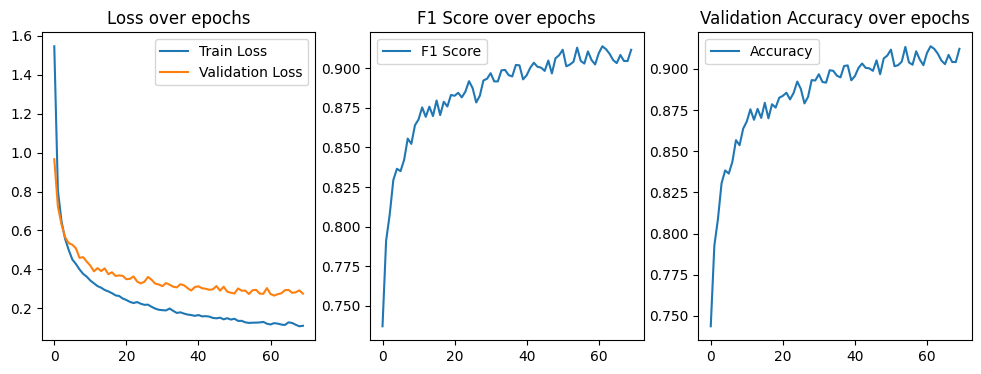

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')

plt.subplot(1, 3, 2)
plt.plot(valid_f1s, label='F1 Score')
plt.legend()
plt.title('F1 Score over epochs')

plt.subplot(1, 3, 3)
plt.plot(valid_accuracies, label='Accuracy')
plt.legend()
plt.title('Validation Accuracy over epochs')
plt.show()
